In [33]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
from sklearn.preprocessing import StandardScaler
sns.set(style='darkgrid', font_scale=2)
import umap.umap_ as umap
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance


In [2]:
df_train = pd.read_csv("data/train.csv")
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
df_test = pd.read_csv("data/test.csv")
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


## Features description
- `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
- `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- `Destination` - The planet the passenger will be debarking to.
- `Age` - The age of the passenger.
- `VIP` - Whether the passenger has paid for special VIP service during the voyage.
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- `Name` - The first and last names of the passenger.
- `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [4]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [5]:
df_train.shape, df_test.shape

((8693, 14), (4277, 13))

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
df_train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [8]:
df_train.isna().sum() / df_train.shape[0] * 100

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64

In [9]:
df_test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [10]:
df_test.isna().sum() / df_test.shape[0] * 100

PassengerId     0.000000
HomePlanet      2.034136
CryoSleep       2.174421
Cabin           2.338087
Destination     2.151040
Age             2.127660
VIP             2.174421
RoomService     1.917232
FoodCourt       2.478373
ShoppingMall    2.291326
Spa             2.361468
VRDeck          1.870470
Name            2.197802
dtype: float64

In [11]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [12]:
df_train.duplicated().sum()

np.int64(0)

In [13]:
df_test.duplicated().sum()

np.int64(0)

In [14]:
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].median())


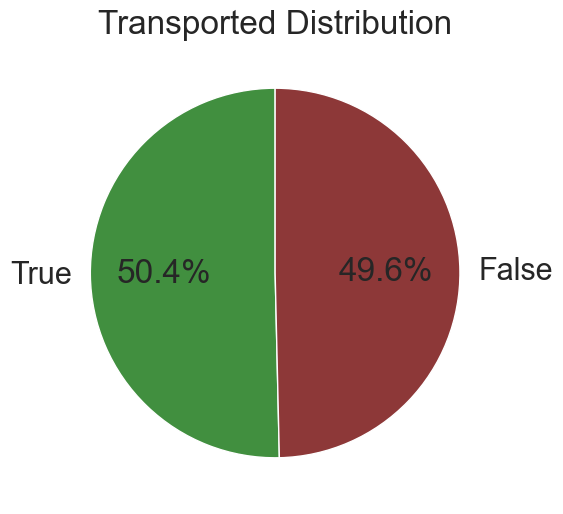

In [15]:
plt.figure(figsize=(8, 6))
df_train["Transported"].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=["#418f3f","#8D3838FF"])
plt.title("Transported Distribution")
plt.ylabel("")
plt.show()

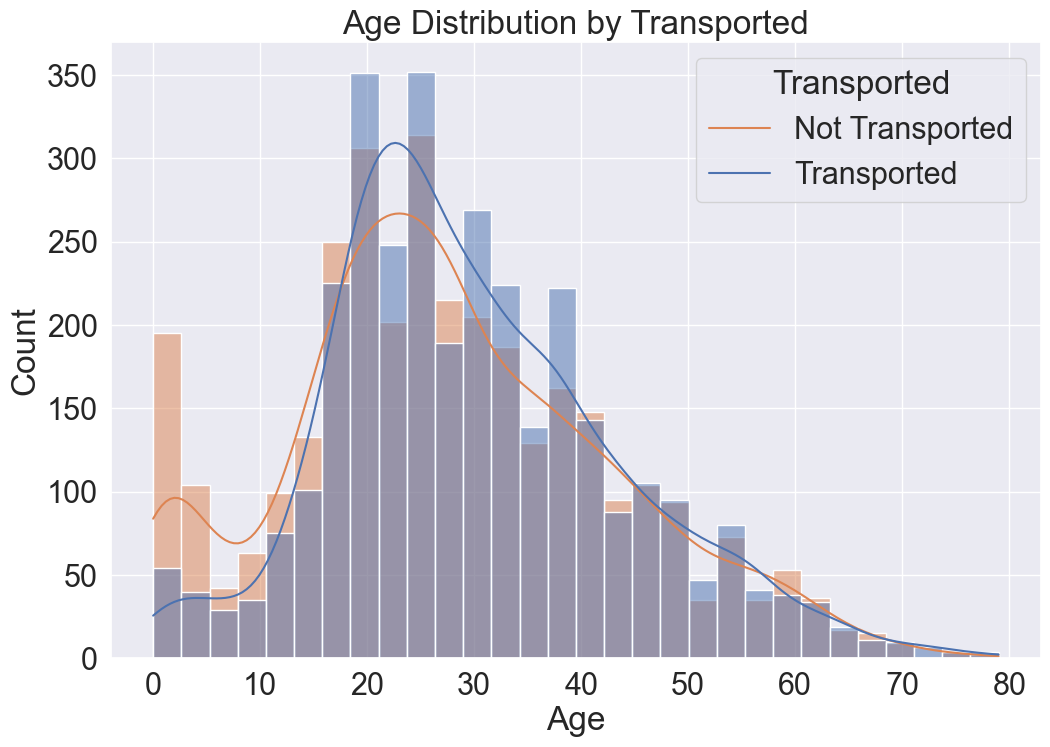

In [16]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df_train, x="Age", hue="Transported", bins=30, kde=True)
plt.title("Age Distribution by Transported")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend(title="Transported", labels=["Not Transported", "Transported"])
plt.show()

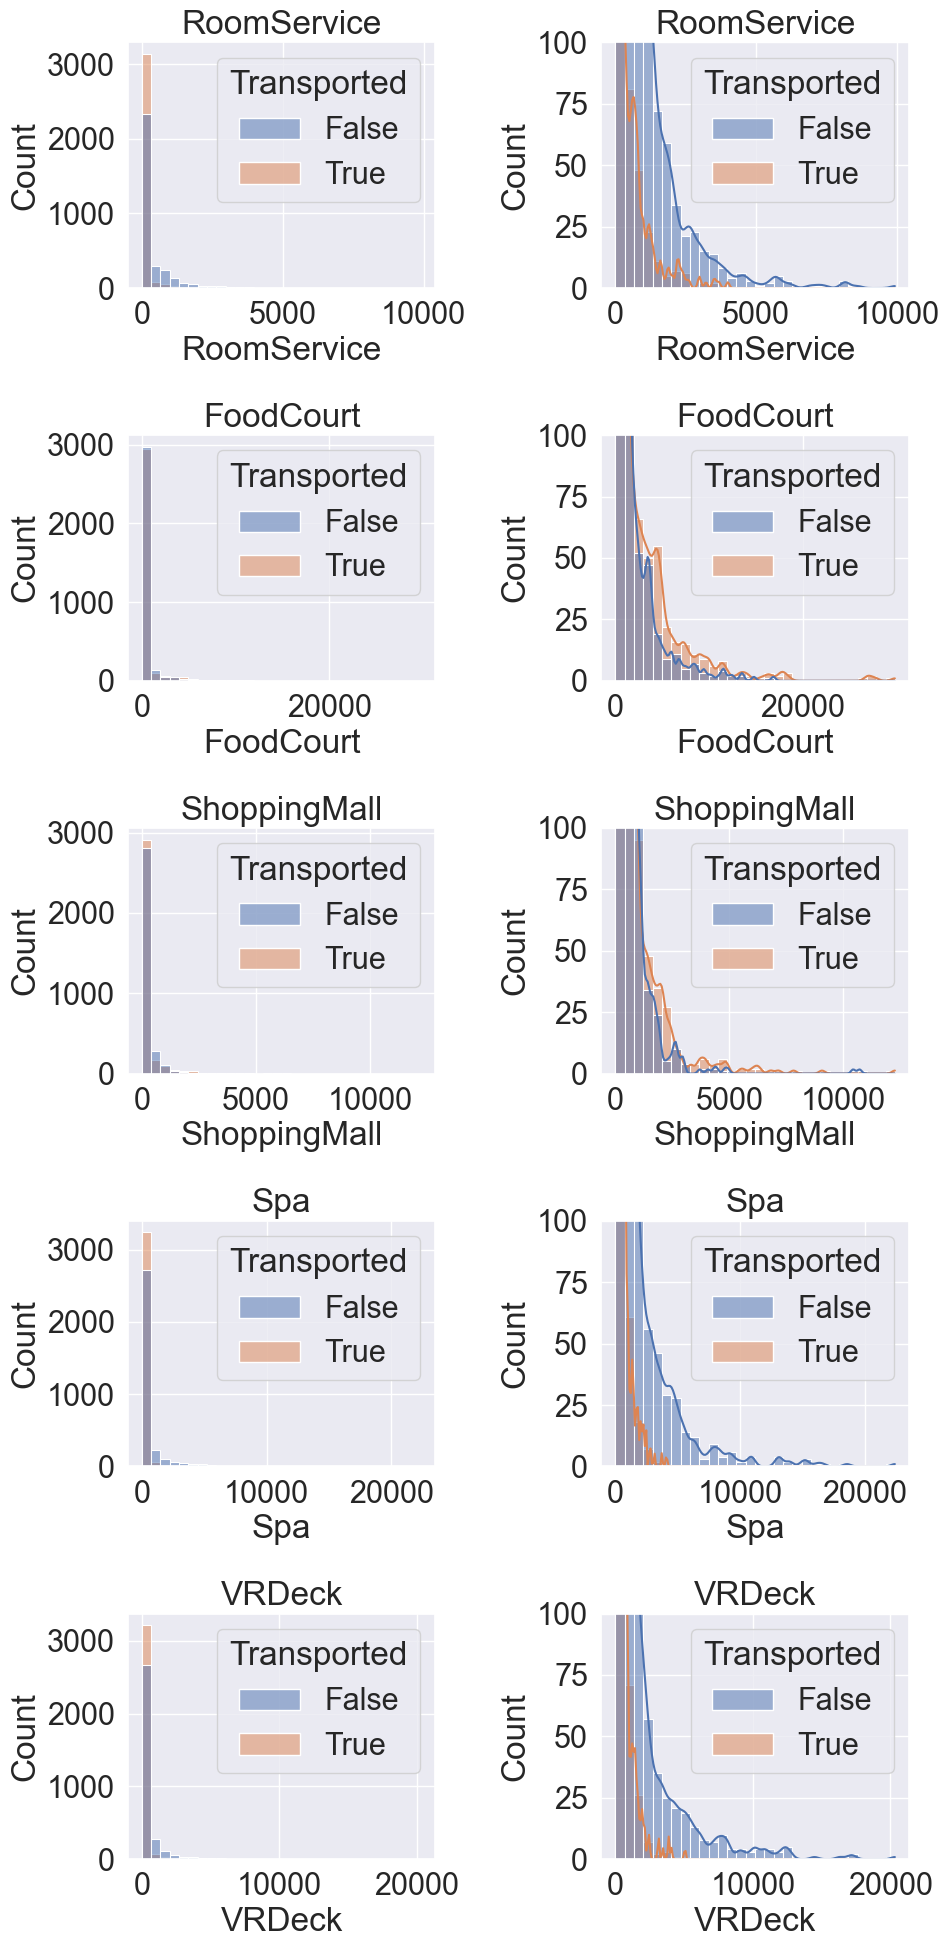

In [17]:
features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
fig = plt.figure(figsize=(10,20))
for i, var_name in enumerate(features):
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=df_train, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=df_train, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout() 
plt.show()


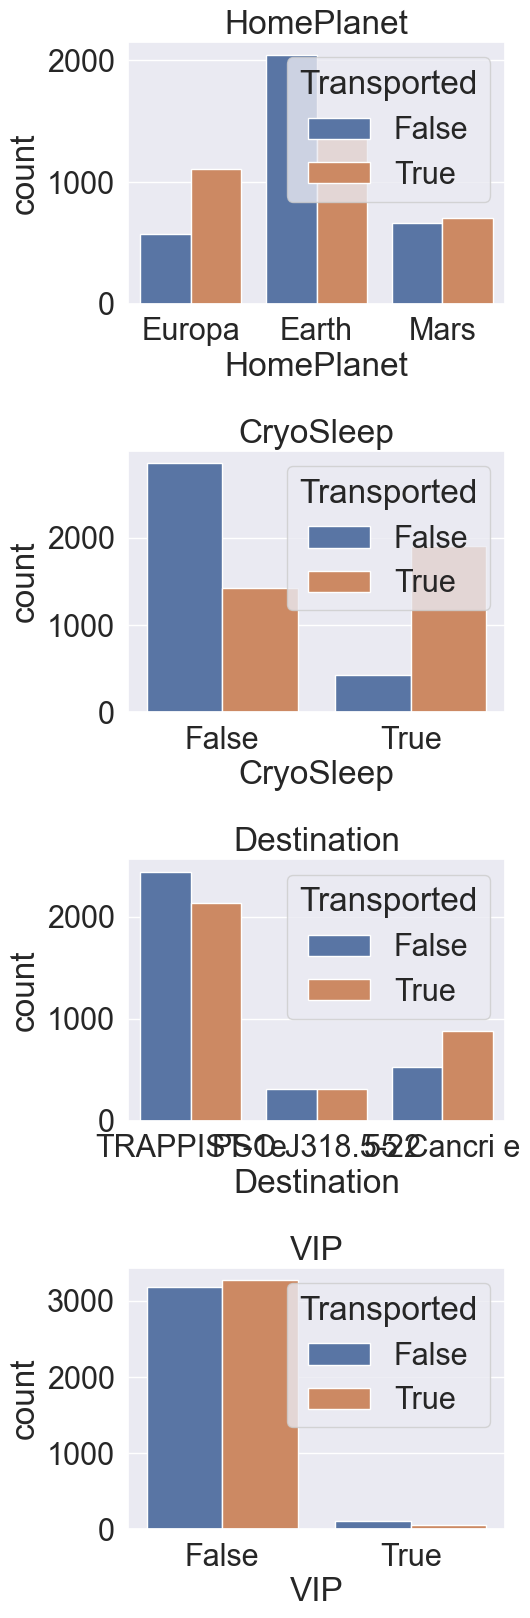

In [18]:
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
fig = plt.figure(figsize=(10,20))
for i, var_name in enumerate(categorical_features):
    ax=fig.add_subplot(5,2,2*i+1)
    sns.countplot(data=df_train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [19]:
df_train["Cabin"].describe()

count        6606
unique       5305
top       C/137/S
freq            7
Name: Cabin, dtype: object

In [20]:
df_train[["CabinDeck", "CabinNum", "CabinSide"]] = df_train["Cabin"].str.split("/", expand=True)

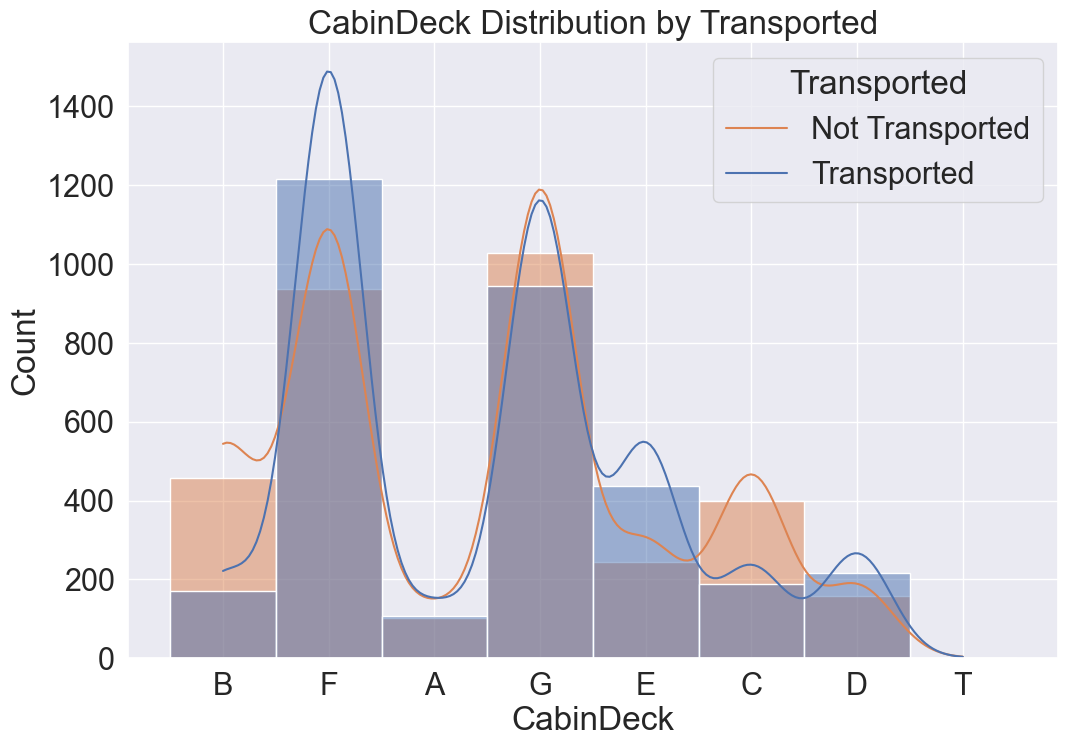

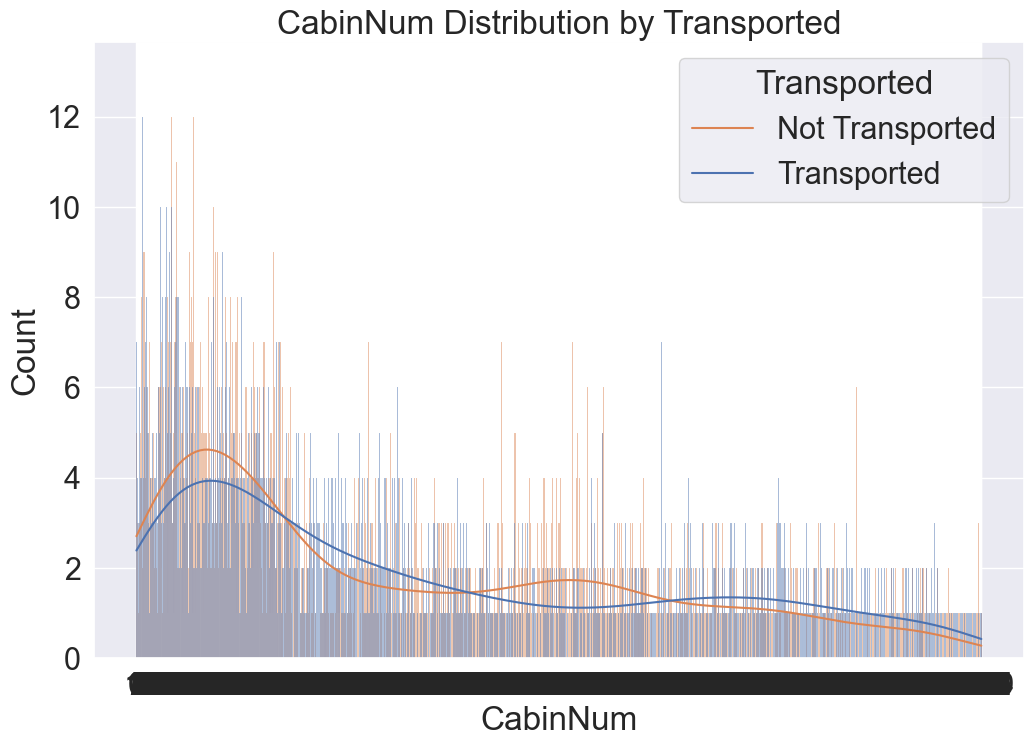

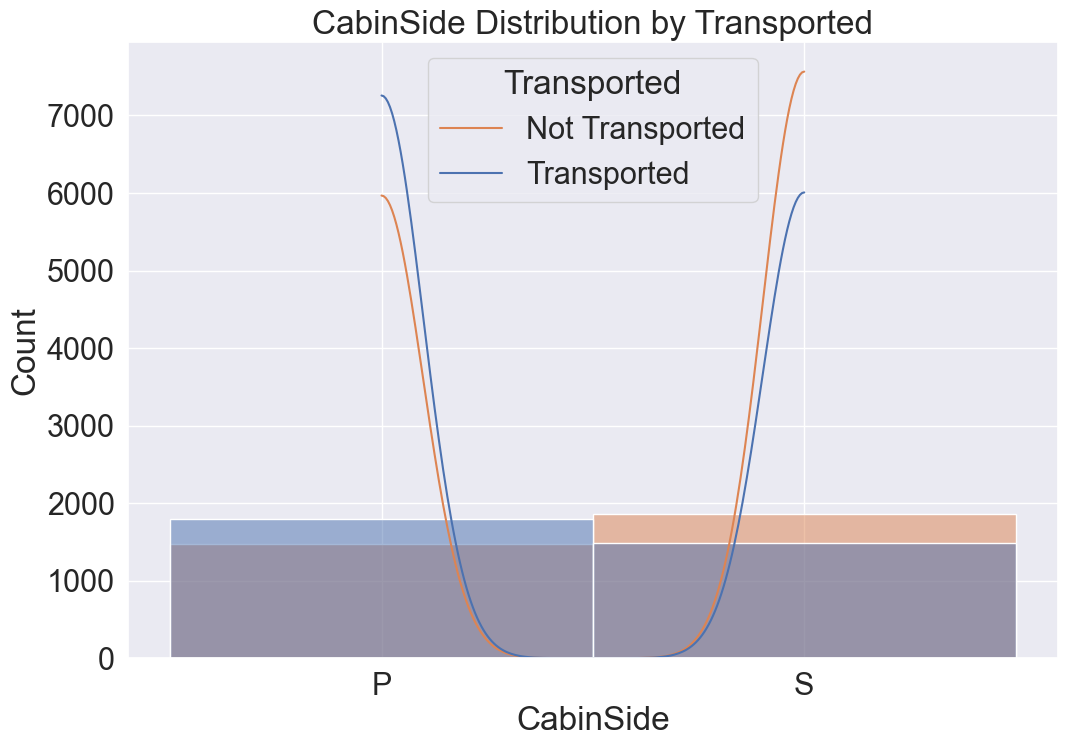

In [21]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df_train, x="CabinDeck", hue="Transported", bins=30, kde=True)
plt.title("CabinDeck Distribution by Transported")
plt.xlabel("CabinDeck")
plt.ylabel("Count")
plt.legend(title="Transported", labels=["Not Transported", "Transported"])
plt.show()
plt.figure(figsize=(12, 8))
sns.histplot(data=df_train, x="CabinNum", hue="Transported", bins=30, kde=True)
plt.title("CabinNum Distribution by Transported")
plt.xlabel("CabinNum")
plt.ylabel("Count")
plt.legend(title="Transported", labels=["Not Transported", "Transported"])
plt.show()
plt.figure(figsize=(12, 8))
sns.histplot(data=df_train, x="CabinSide", hue="Transported", bins=30, kde=True)
plt.title("CabinSide Distribution by Transported")
plt.xlabel("CabinSide")
plt.ylabel("Count")
plt.legend(title="Transported", labels=["Not Transported", "Transported"])
plt.show()

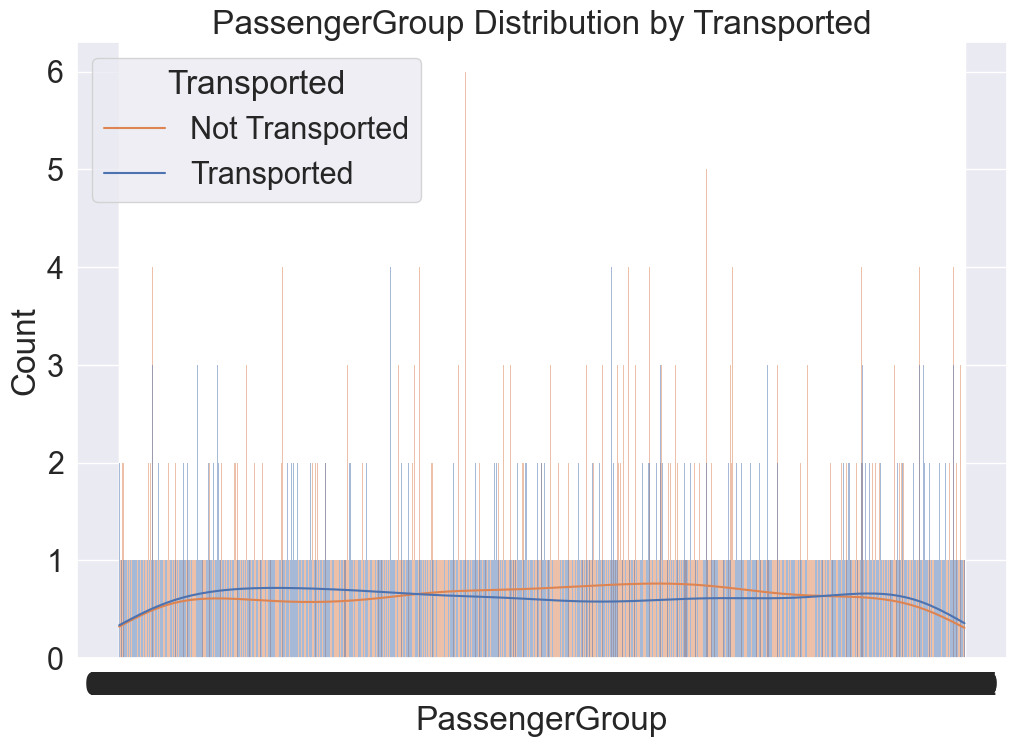

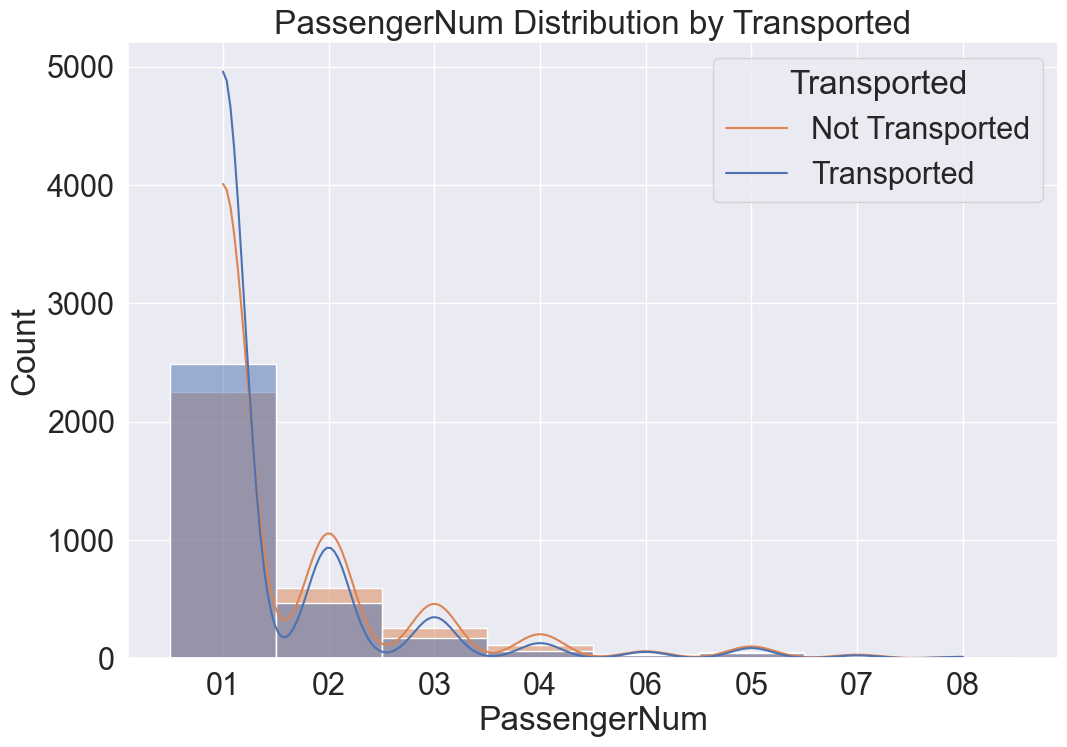

In [22]:
df_train[["PassengerGroup", "PassengerNum"]] = df_train["PassengerId"].str.split("_", expand=True)
plt.figure(figsize=(12, 8))
sns.histplot(data=df_train, x="PassengerGroup", hue="Transported", bins=30, kde=True)
plt.title("PassengerGroup Distribution by Transported")
plt.xlabel("PassengerGroup")
plt.ylabel("Count")
plt.legend(title="Transported", labels=["Not Transported", "Transported"])
plt.show()
plt.figure(figsize=(12, 8))
sns.histplot(data=df_train, x="PassengerNum", hue="Transported", bins=30, kde=True)
plt.title("PassengerNum Distribution by Transported")
plt.xlabel("PassengerNum")
plt.ylabel("Count")
plt.legend(title="Transported", labels=["Not Transported", "Transported"])
plt.show()

In [23]:
df_test[["CabinDeck", "CabinNum", "CabinSide"]] = df_test["Cabin"].str.split("/", expand=True)
df_test[["PassengerGroup", "PassengerNum"]] = df_test["PassengerId"].str.split("_", expand=True)
df_train.drop(columns=["PassengerId", "Name", "Cabin", "PassengerGroup", "PassengerNum", "VIP"], inplace=True)
df_test.drop(columns=["PassengerId", "Name", "Cabin", "PassengerGroup", "PassengerNum", "VIP"], inplace=True)
df_train["CryoSleep"] = df_train["CryoSleep"].map({True: 1, False: 0})
df_test["CryoSleep"] = df_test["CryoSleep"].map({True: 1, False: 0})
df_train["HomePlanet"] = df_train["HomePlanet"].map({"Earth": 0, "Mars": 1, "Europa": 2})
df_test["HomePlanet"] = df_test["HomePlanet"].map({"Earth": 0, "Mars": 1, "Europa": 2})
df_train["Destination"] = df_train["Destination"].map({"TRAPPIST-1e": 0, "55 Cancri e": 1, "PSO J318.5-22": 2})
df_test["Destination"] = df_test["Destination"].map({"TRAPPIST-1e": 0, "55 Cancri e": 1, "PSO J318.5-22": 2})
df_train["CabinDeck"] = df_train["CabinDeck"].map({"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6, "T": 7})
df_test["CabinDeck"] = df_test["CabinDeck"].map({"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6, "T": 7})
df_train["CabinNum"] = df_train["CabinNum"].astype(float)
df_test["CabinNum"] = df_test["CabinNum"].astype(float)
df_train["CabinSide"] = df_train["CabinSide"].map({"P": 0, "S": 1})
df_test["CabinSide"] = df_test["CabinSide"].map({"P": 0, "S": 1})
df_train.drop(columns=["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"], inplace=True)
df_test.drop(columns=["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"], inplace=True)

In [24]:
df_train.head()

,HomePlanet,CryoSleep,Destination,Age,Transported,CabinDeck,CabinNum,CabinSide
0,2,0,0,39.0,False,1,0.0,0
1,0,0,0,24.0,True,5,0.0,1
2,2,0,0,58.0,False,0,0.0,1
3,2,0,0,33.0,False,0,0.0,1
4,0,0,0,16.0,True,5,1.0,1


In [25]:
df_test.head()

,HomePlanet,CryoSleep,Destination,Age,CabinDeck,CabinNum,CabinSide
0,0,1,0,27.0,6,3.0,1
1,0,0,0,19.0,5,4.0,1
2,2,1,1,31.0,2,0.0,1
3,2,0,0,38.0,2,1.0,1
4,0,0,0,20.0,5,5.0,1


In [28]:
X = df_train.drop(columns=["Transported"])
y = df_train["Transported"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2],
    "alpha": [0, 0.1, 1],
    "lambda": [1, 1.5, 2]
}

xgb_model = XGBClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    verbose=1,
    n_jobs=-1,
    scoring="f1"
)

grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Fitting 3 folds for each of 6561 candidates, totalling 19683 fits
Best parameters found:  {'alpha': 1, 'colsample_bytree': 0.6, 'gamma': 0.1, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 200, 'subsample': 1.0}
Confusion Matrix:
[[538 115]
 [195 474]]
Classification Report:
              precision    recall  f1-score   support

       False       0.73      0.82      0.78       653
        True       0.80      0.71      0.75       669

    accuracy                           0.77      1322
   macro avg       0.77      0.77      0.76      1322
weighted avg       0.77      0.77      0.76      1322

Accuracy:  0.7655068078668684


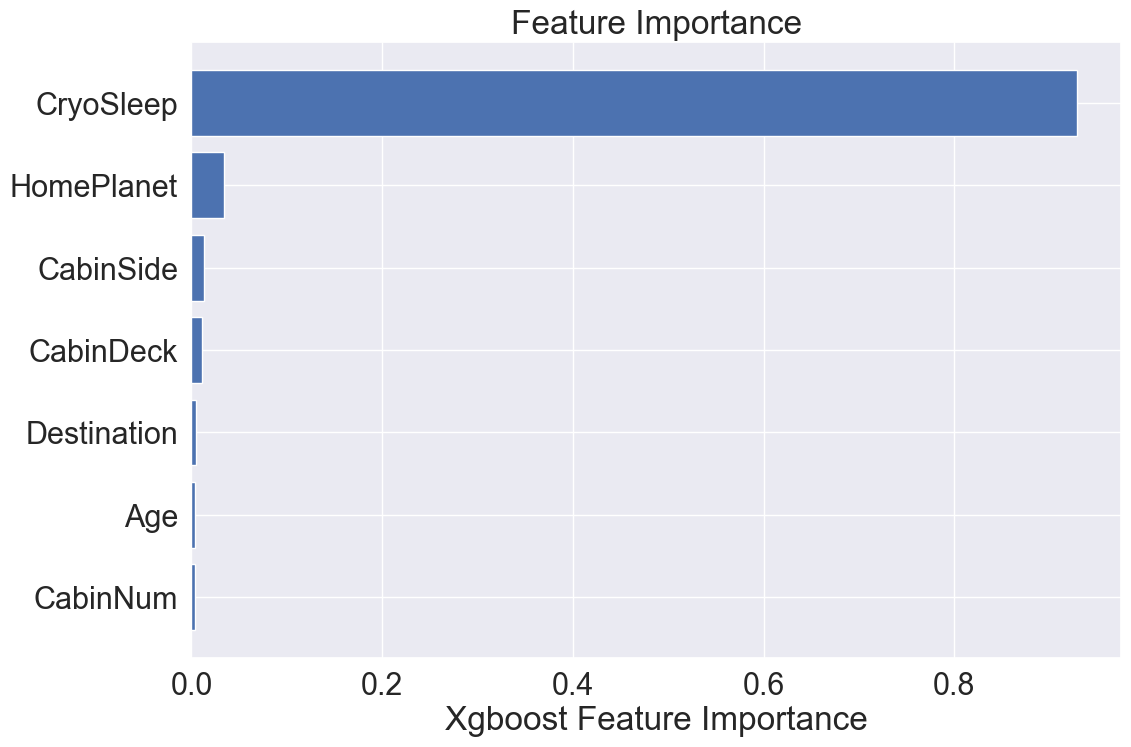

In [32]:
importance = best_model.feature_importances_
feature_names = X.columns
features = np.array(feature_names)
sorted_idx = importance.argsort()

plt.figure(figsize=(12, 8))
plt.barh(features[sorted_idx], importance[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.title("Feature Importance")
plt.show()

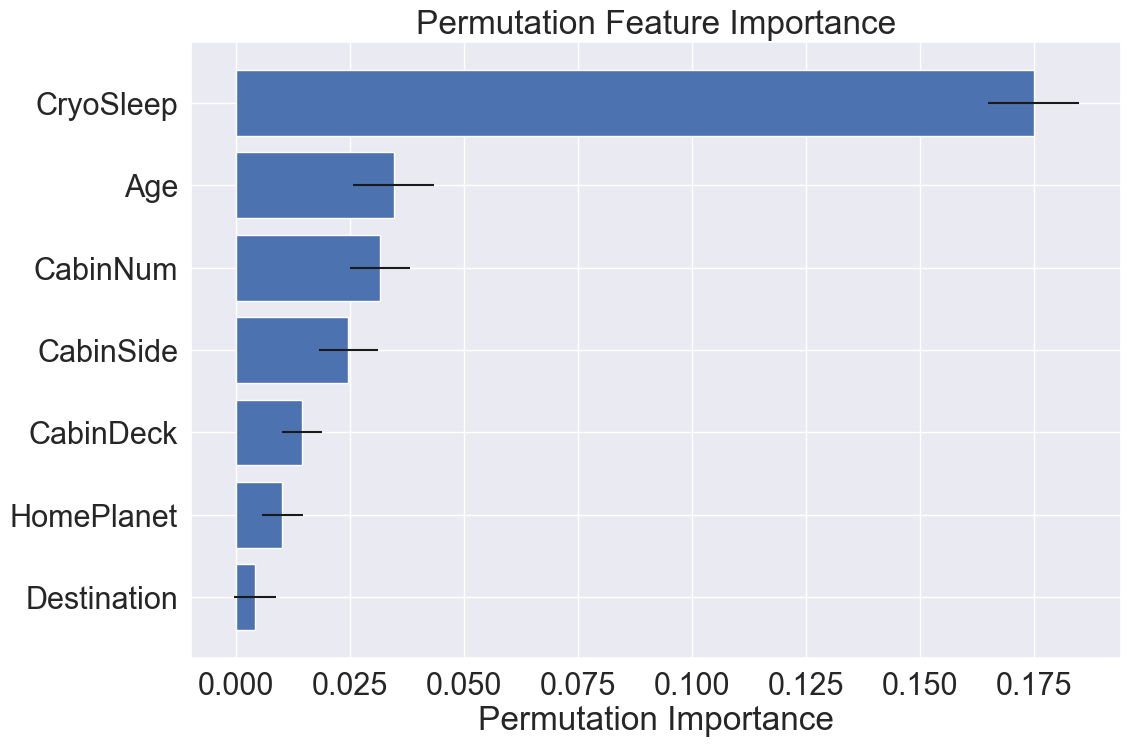

In [ ]:
perm_importance = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=15,
    random_state=42,
    scoring="f1"
)

perm_df = pd.DataFrame(
    {
    "Feature": X.columns,
    "Importance": perm_importance.importances_mean,
    "Std": perm_importance.importances_std
    }
).sort_values(by="Importance", ascending=True)

plt.figure(figsize=(12, 8))
plt.barh(perm_df["Feature"], perm_df["Importance"], xerr=perm_df["Std"])
plt.xlabel("Permutation Importance")
plt.title("Permutation Feature Importance")
plt.show()